# Testing things on Aids2 dataset

In this notebook we train a decision tree regressor to predict the time of death of individuals based on the data given in the Aids2 dataset. The decision tree treats censored data like any other example of the dataset yet the concordance index seems high. 
We don't know how to explain this high score, maybe we are misusing the lifelines package concordance_index scoring function. 

In [5]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Dataset preparation

In [6]:
# Loading data
df = pd.read_csv('Aids2.csv')
# Converting categorical features to one hot représentation 
df = pd.get_dummies(df, columns=['state', 'sex', 'status', 'T.categ'], drop_first=True)
# Stratified split (since the classifiers are fast, we later use Cross Validation instead
# of on split).
train, valid = train_test_split(df, test_size=0.3, random_state=42)
# Getting labels ready and removing target values from the training and valid sets
y_train = train['death'].values
y_valid = valid['death'].values
X_train = train.drop(['death', 'Unnamed: 0'], axis=1).values
X_valid = valid.drop(['death', 'Unnamed: 0'], axis=1).values
# Checking the shapes
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

df.head()

(1990, 14)
(1990,)
(853, 14)
(853,)


,Unnamed: 0,diag,death,age,state_Other,state_QLD,state_VIC,sex_M,status_D,T.categ_haem,T.categ_het,T.categ_hs,T.categ_hsid,T.categ_id,T.categ_mother,T.categ_other
0,1,10905,11081,35,0,0,0,1,1,0,0,1,0,0,0,0
1,2,11029,11096,53,0,0,0,1,1,0,0,1,0,0,0,0
2,3,9551,9983,42,0,0,0,1,1,0,0,1,0,0,0,0
3,4,9577,9654,44,0,0,0,1,1,1,0,0,0,0,0,0
4,5,10015,10290,39,0,0,0,1,1,0,0,1,0,0,0,0


In [55]:
# Import some classifiers and evaluation fonctions
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lifelines.utils import concordance_index
from sklearn.metrics import mean_absolute_error, make_scorer, cohen_kappa_score

## Simple decision tree 

In [8]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
pred = clf.predict(X_valid)

In [9]:
print(concordance_index(valid['death'], pred, valid['status_D']))
print(mean_absolute_error(y_valid, pred))

0.896443390444
187.923798359


## Decision tree with cv=5

In [57]:
# We take all the data and we perform 5-fold cv on it with the same decision Tree
X = df.drop(['death', 'Unnamed: 0'], axis=1).values
y = df['death'].values
clf = DecisionTreeRegressor()
cv_scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(concordance_index))
#cv_scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(cohen_kappa_score))
print('%f +/- %f'%(cv_scores.mean(), cv_scores.var()))

0.843728 +/- 0.005360


10669.0
9983


## Knn with cv=5

In [67]:
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
clf = DecisionTreeRegressor()
cv_scores_ci = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(concordance_index))
cv_scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
print('%f +/- %f'%(cv_scores.mean(), cv_scores.var()))
print(cv_scores_ci.mean())

193.143409 +/- 11578.049344
0.844416225897


## Linear regression

In [63]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
cv_scores_ci = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(concordance_index))
cv_scores_rmse = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(mean_absolute_error))
print(cv_scores_ci.mean())
print(cv_scores_rmse.mean())

0.864152029212
287.117636655


## Coxph 

In [68]:
from lifelines import CoxPHFitter

In [69]:
cox = CoxPHFitter()
cox.fit(train, duration_col='death', event_col='status_D', show_progress=True)

Iteration 1: norm_delta = 1.50375, step_size = 0.95000, ll = -8844.11682, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.57818, step_size = 0.95000, ll = -8184.69789, seconds_since_start = 0.2
Iteration 3: norm_delta = 0.14768, step_size = 0.95000, ll = -8110.13244, seconds_since_start = 0.3
Iteration 4: norm_delta = 0.02544, step_size = 0.95000, ll = -8106.54944, seconds_since_start = 0.4
Iteration 5: norm_delta = 0.00186, step_size = 0.95000, ll = -8106.46328, seconds_since_start = 0.4
Iteration 6: norm_delta = 0.00010, step_size = 0.95000, ll = -8106.46284, seconds_since_start = 0.5
Iteration 7: norm_delta = 0.00000, step_size = 0.95000, ll = -8106.46284, seconds_since_start = 0.6
Convergence completed after 7 iterations.


<lifelines.CoxPHFitter: fitted with 1990 observations, 760 censored>

In [70]:
cox.print_summary()

n=1990, number of events=1230

                  coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
Unnamed: 0     -0.0010     0.9990    0.0001 -11.1466 0.0000     -0.0012     -0.0008  ***
diag           -0.0015     0.9985    0.0001 -26.1820 0.0000     -0.0016     -0.0014  ***
age             0.0108     1.0109    0.0030   3.6284 0.0003      0.0050      0.0167  ***
state_Other     1.4043     4.0726    0.1808   7.7665 0.0000      1.0499      1.7587  ***
state_QLD       1.2631     3.5365    0.1503   8.4039 0.0000      0.9685      1.5577  ***
state_VIC       1.7134     5.5476    0.1682  10.1871 0.0000      1.3837      2.0430  ***
sex_M           0.1536     1.1661    0.2166   0.7093 0.4781     -0.2709      0.5782     
T.categ_haem   -0.1315     0.8768    0.2784  -0.4723 0.6367     -0.6772      0.4142     
T.categ_het    -1.0967     0.3340    0.3410  -3.2163 0.0013     -1.7650     -0.4284   **
T.categ_hs     -0.2828     0.7536    0.1719  -1.6456 0.0998     -0.6197      0.

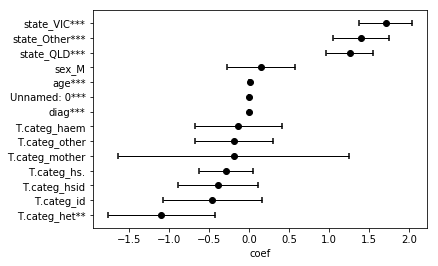

In [71]:
%matplotlib inline
cox.plot()

In [85]:
hazard_tr, hazard_va = cox.predict_partial_hazard(train), cox.predict_partial_hazard(valid)
median_tr, median_va = cox.predict_median(train), cox.predict_median(valid).replace([np.inf, -np.inf], np.nan).fillna(value=1e4)
score_tr = concordance_index(train['death'], -hazard_tr, train['status_D'])
score_va = concordance_index(valid['death'], -hazard_va, valid['status_D'])
score_va_2 = concordance_index(valid['death'], -median_va, valid['status_D'])
print(score_va)
print(score_va_2)
print(type(median_va))
print(mean_absolute_error(valid['death'], -median_va))

0.842961070802
0.536342689905
<class 'pandas.core.frame.DataFrame'>
21461.3739742


In [27]:
print(mean_absolute_error(y_valid, -hazard_va))

10967.2200551


In [42]:
print(hazard_va.shape[0])
t = hazard_va.values
print(t.shape)
print(t[:10])
print(y_valid[:10])

853
(853, 1)
[[ 3.6743199 ]
 [ 4.67968058]
 [ 1.62871059]
 [ 0.76483813]
 [ 0.47680879]
 [ 6.75465402]
 [ 0.56925567]
 [ 1.22429468]
 [ 3.26131952]
 [ 0.83727818]]
[10103 10480 10984 11495 11504  9894 11504 11504 10032 11504]
